In [1]:
import analysis
import analyze_v1_11_tools as tools1_11
import joblib
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import run_models
import scipy.stats
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

analysis.set_mpl_style()

r = tools1_11.ro.r
r_with_vars = tools1_11.r_with_vars

tomov_interop could not load matlab


R[write to console]: Loading required package: dfidx

R[write to console]: 
Attaching package: ‘dfidx’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




In [2]:
exp = analysis.load_exp1()

Modal sequence length=99 ['CircleGraphNavigationInstruction', 'SimpleInstruction', 'HTMLForm', 'CircleGraphNavigationx2', 'MapInstruction', 'CircleGraphNavigationx2', 'SimpleInstruction', 'CircleGraphNavigationx60', 'HTMLForm', 'CirclePathIdentificationx2', 'SimpleInstruction', 'CirclePathIdentificationx10', 'HTMLForm', 'CirclePathIdentificationx2', 'SimpleInstruction', 'CirclePathIdentificationx11', 'survey-multi-choice']
summary of participant data. total participants 966
	type complete | # participants 952
	type did-at-most-12-things-then-restart | # participants 5
	type instructions-twice | # participants 1
	type unusable: completed after restart | # participants 8
Modal sequence length=99 ['CircleGraphNavigationInstruction', 'SimpleInstruction', 'HTMLForm', 'CircleGraphNavigationx2', 'MapInstruction', 'CircleGraphNavigationx2', 'SimpleInstruction', 'CircleGraphNavigationx60', 'HTMLForm', 'CirclePathIdentificationx2', 'SimpleInstruction', 'CirclePathIdentificationx10', 'HTMLForm', 

# Intro of *Experiment Results*

## Exclusion criteria

In [3]:
def meansd(arr, *, percent=False):
    M = np.mean(arr)
    SD = np.std(arr)
    if percent:
        print(f'$M={100*M:.0f}\\%$')
    else:
        print(f'${M=:.2f}$ ${SD=:.2f}$')


In [4]:
meansd(len(exp.participants)/len(exp._rawexp.participants), percent=True)

$M=85\%$


## Descriptive stats

In [5]:
meansd(np.array([ped.elapsed_minutes() for ped in exp.participants]))

$M=17.17$ $SD=8.02$


In [6]:
learn = []
for p in exp.participants:
    gi = p.config_idx()['graph']
    for t in p.navigation_trials(return_obj=True):
        if t.is_filler_trial:
            continue
        learn.append(dict(
            pid=p.pid,
            is_early=t.is_early_trial,
            graph=gi,
            rel_to_optimal_percent=t.action_count_relative_to_optimal,
            is_optimal_percent=t.is_optimal,
            rt_sec=t.trial_duration_sec,
            map_rt_sec=t.map_duration_sec,
            map_num_states=t.map_state_count,
            map_state_vis_sec=t.map_state_hover_duration_sec,
            state_repeated_percent=t.has_repeated_state_visit,
        ))
learn = pd.DataFrame(learn)

early = learn.is_early
late = ~early

assert early.sum() == late.sum()
assert np.isclose(early.sum(), learn.shape[0]/2)

for k in [
    'rel_to_optimal_percent',
    'rt_sec',
    'map_rt_sec',
    'map_num_states',
    'map_state_vis_sec',
    'is_optimal_percent',
    'state_repeated_percent',
]:
    p = 'percent' in k
    print(k)

    for name, var in [
        ('early', early),
        ('late', late),
    ]:
        print(name, end='\t')
        meansd(getattr(learn[var], k), percent=p)
    print()

rel_to_optimal_percent
early	$M=136\%$
late	$M=120\%$

rt_sec
early	$M=10.30$ $SD=29.74$
late	$M=7.60$ $SD=11.19$

map_rt_sec
early	$M=9.01$ $SD=20.97$
late	$M=2.98$ $SD=12.66$

map_num_states
early	$M=5.43$ $SD=8.70$
late	$M=1.38$ $SD=3.99$

map_state_vis_sec
early	$M=2.52$ $SD=7.23$
late	$M=0.60$ $SD=9.04$

is_optimal_percent
early	$M=70\%$
late	$M=79\%$

state_repeated_percent
early	$M=14\%$
late	$M=9\%$



## Were there significant differences in participants counts by graph, after exclusion criteria?

In [7]:
def participant_counts_per_graph(exp):
    grouped = exp.group_participants_by(lambda p: p.config_idx()['graph'])
    return [len(grouped[i]) for i in range(len(grouped))]
before_ct = participant_counts_per_graph(exp._rawexp)
after_ct = participant_counts_per_graph(exp)
diff_ct = (np.array(before_ct) - np.array(after_ct)).tolist()
print(f'range before {min(before_ct)}-{max(before_ct)}')
print(f'range after {min(after_ct)}-{max(after_ct)}')
print(f'range of per-graph differences {min(diff_ct)}-{max(diff_ct)}')

range before 27-34
range after 21-30
range of per-graph differences 3-8


In [8]:
# https://mgimond.github.io/Stats-in-R/ChiSquare_test.html#3_two_factor_classification
r_with_vars('''show(chisq.test(df))''', df=tools1_11.convert_df_to_rdf(pd.DataFrame(dict(excluded=diff_ct, not_excluded=after_ct))))


	Pearson's Chi-squared test

data:  df
X-squared = 14.989, df = 29, p-value = 0.9851



<rpy2.rinterface_lib.sexp.NULLType object at 0x1729388c0> [RTYPES.NILSXP]

In [9]:
# Compute the X-squared value here explicitly to double check.

def deviation_from_expected(exp, actual):
    exp = exp / exp.sum() * actual.sum()
    return ((exp - actual)**2 / exp).sum()

def twofactor_chisq(f1, f2):
    tot = f1 + f2
    return deviation_from_expected(tot, f1) + deviation_from_expected(tot, f2)

twofactor_chisq(np.array(after_ct), np.array(diff_ct))

14.98874968831689

# *Subgoal probes are internally consistent and predict behavior*

## Correlation within tasks

In [10]:
def participant_probe_choices_by_graph(exp, copy_, ntasks):
    # First group particpants by graph
    by_g = exp.group_participants_by(lambda p: p.config_idx()['graph'])

    nstates = len(exp.mdps()[0].state_list) # just trying to avoid hardcoding

    rv = {}
    for gi, ps in by_g.items():
        allcts = []
        for p in ps:
            cts = p.probe_choice_counts(copy=copy_)
            assert cts.sum() == ntasks
            allcts.append(cts)
        rv[gi] = (ps, allcts)
    return rv

In [11]:
for copy_, ntasks in [
    ('solway2014', 10),
    ('subgoal', 10),
    ('busStop', 1),
]:
    choices = participant_probe_choices_by_graph(exp, copy_, ntasks)

    for name, subtract_ct in [('corr-to-all', False), ('corr-to-all-except-curr', True)]:
        corrs = []
        for gi, (ps, allcts) in choices.items():
            nstates = len(ps[0].mdp().state_list) # just trying to avoid hardcoding
            summed = np.sum(allcts, axis=0)
            assert len(summed) == nstates
            assert summed.sum() == len(ps) * ntasks
            corrs.extend([
                scipy.stats.pearsonr(
                    ct,
                    # Similar results whether or not we include current participant.
                    (summed - ct if subtract_ct else summed),
                )[0]
                for ct in allcts
            ])
        print(f'{name} corr={np.mean(corrs):.2f}')

corr-to-all corr=0.71
corr-to-all-except-curr corr=0.69
corr-to-all corr=0.64
corr-to-all-except-curr corr=0.61
corr-to-all corr=0.37
corr-to-all-except-curr corr=0.29


## Correlation between tasks

In [12]:
labs = []
corr = np.zeros((3, len(exp.mdps()) * len(exp.mdps()[0].state_list)))
for i, p in enumerate(analysis.probes):
    choices = participant_probe_choices_by_graph(exp, p.key, 10 if p.random_effects else 1)
    vec = []
    for gi, (ps, allcts) in choices.items():
        m = np.mean(allcts, axis=0)
        nstates = len(ps[0].mdp().state_list)
        assert len(m) == nstates
        vec.append(m)
    vec = np.concatenate(vec)
    assert vec.shape == (len(choices) * nstates,)
    corr[i] = vec
    labs.append(p.name)
pd.DataFrame(np.corrcoef(corr), index=labs, columns=labs)


,Explicit Probe,Implicit Probe,Teleportation Question
Explicit Probe,1.000000,0.982077,0.582863
Implicit Probe,0.982077,1.000000,0.581718
Teleportation Question,0.582863,0.581718,1.000000


In [13]:
import itertools
for (ai, a), (bi, b) in itertools.combinations(enumerate(analysis.probes), r=2):
    print(a.name, b.name)
    c, pv = scipy.stats.pearsonr(corr[ai], corr[bi])
    print(f'($r={c:.02f}$, ${analysis.pvalue(pv)}$)')


Explicit Probe Implicit Probe
($r=0.98$, $p < .001$)
Explicit Probe Teleportation Question
($r=0.58$, $p < .001$)
Implicit Probe Teleportation Question
($r=0.58$, $p < .001$)


## Is subgoal selection associated with more efficient behavior? Measured by relative path length and RT.

In [14]:
df = []
for p in exp.participants:
    nav_trials = [
        t
        for t in p.navigation_trials(return_obj=True)
        if not t.is_filler_trial
    ]

    df.append(dict(
        subgoal_choice_count=p.subgoal_choice_count_on_explicit_trials(),
        relative_path_length=np.mean([
            t.action_count_relative_to_optimal
            for t in nav_trials
        ]),
        log_navigation_rt_sec=np.mean([
            np.log(t.trial_duration_sec)
            for t in nav_trials
        ]),
    ))

df = pd.DataFrame(df)

In [15]:
for var in df.columns:
    print(var)
    c, pv = scipy.stats.pearsonr(df.subgoal_choice_count, df[var])
    print(f'($r={c:.02f}$, ${analysis.pvalue(pv)}$)')
    print()

subgoal_choice_count
($r=1.00$, $p < .001$)

relative_path_length
($r=-0.29$, $p < .001$)

log_navigation_rt_sec
($r=0.01$, $p = .858$)



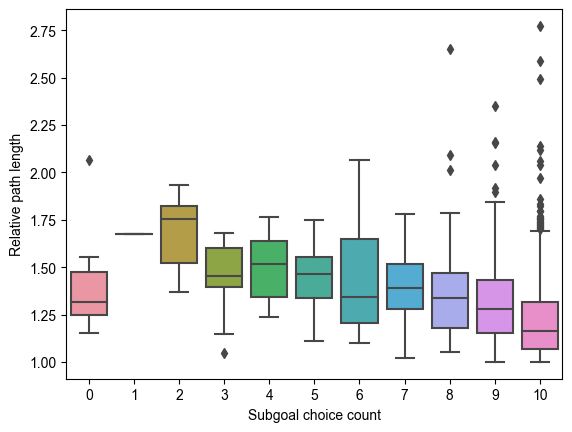

In [16]:
plt.figure()
sns.boxplot(y='relative_path_length', x='subgoal_choice_count', data=df)
plt.xlabel('Subgoal choice count')
plt.ylabel('Relative path length')
analysis.savefig('gcr-pathlen.*')

## Are people's navigation choices consistent with their subsequent subgoal choices?

- Note: for "goal" responses for "subgoal" probe, the goal (their "subgoal choice") must always be consistent with their selection, since the goal appears on all paths.

In [17]:
import pred_optimal_choice

In [18]:
pred_optimal_choice.PredictOptimalChoice(exp).multinomial_model('subgoal')
print('\n'*10)
pred_optimal_choice.PredictOptimalChoice(exp).multinomial_model('solway2014')


Call:
mlogit(formula = choice ~ probe_choice_match_subgoal - 1 | 0 | 
    0, data = dff, rpar = NULL, R = R, halton = NA, panel = FALSE, 
    method = "nr")

Frequencies of alternatives:choice
        0         1         2         3         4         5 
0.3952046 0.4241422 0.1550227 0.0206697 0.0024804 0.0024804 

nr method
3 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.0023 
successive function values within tolerance limits 

Coefficients :
                               Estimate Std. Error z-value  Pr(>|z|)    
probe_choice_match_subgoalTRUE 0.463387   0.063204  7.3317 2.274e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -2161.8
Likelihood ratio test

Model 1: choice ~ -1
Model 2: choice ~ probe_choice_match_subgoal - 1 | 0 | 0
  #Df  LogLik Df  Chisq Pr(>Chisq)    
1   0 -2189.2                         
2   1 -2161.8  1 54.689  1.412e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1












Call:
mlogit(formula = ch

observed is larger than 100000 / 100000 samples -- percentile=100.00%
observed 0.7544439851178173 expected mean 0.7054223508336778 expected variance 4.402077971634882e-05
MC-sampled mean 0.7054408061182307 MC-sampled variance 4.3899377120720436e-05


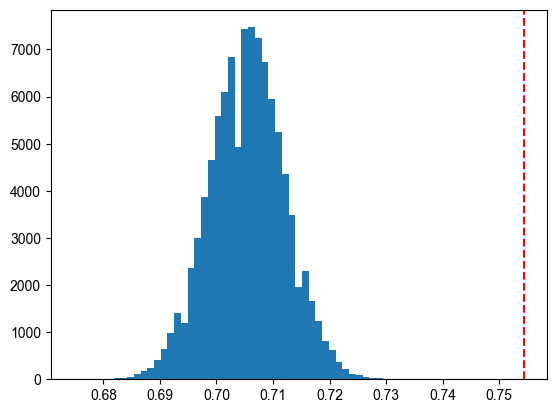

observed is larger than 100000 / 100000 samples -- percentile=100.00%
observed 0.7064902852418354 expected mean 0.6519911809287584 expected variance 4.761549952226423e-05
MC-sampled mean 0.6520124844977263 MC-sampled variance 4.7446981883979314e-05


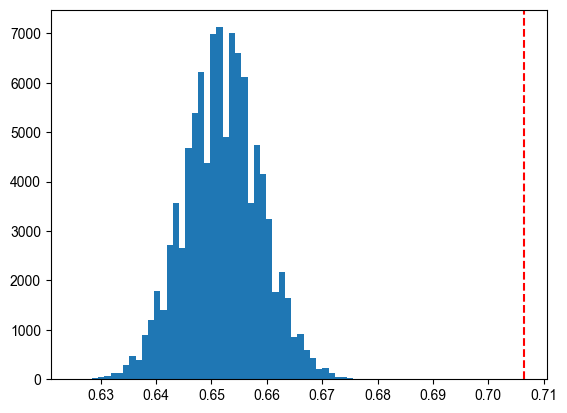

In [19]:
# seed = np.random.randint(2**30)
seed = 470688461

plt.figure()
pred_optimal_choice.PredictOptimalChoice(exp).mc_test('subgoal', seed=seed)
plt.show()

plt.figure()
pred_optimal_choice.PredictOptimalChoice(exp).mc_test('solway2014', seed=seed)
plt.show()

# How many people used a visual aid?

In [20]:
collections.Counter([
    p.questiondata['picture_draw']
    for p in exp.participants
])

Counter({'Rarely looked': 65,
         'Did not draw/take picture': 603,
         'Sometimes looked': 90,
         'Often looked': 48})

# Appendix: *Predicting navigation response times*

Does RT change as predicted by in-the-moment planning?

## Is participant RT higher at self-reported subgoals?

In [21]:
df = []
for p in exp.participants:
    # First, we gather probe-specific subgoal choices
    seen = {}
    for t in p.probe_trials(return_obj=True):
        seen.setdefault(t.row.data['copy'], {})[t.start, t.goal] = t.selected

    for copy in analysis.probes:
        if copy.key == 'busStop': continue

        for t in p.navigation_trials(return_obj=True):
            sg = seen[copy.key].get((t.start, t.goal))
            # Skip if not paired to a probe choice.
            if sg is None:
                continue
            # Skip if behavior is not optimal.
            if not t.is_optimal:
                continue
            # Skip if the subgoal is not along their path.
            if sg not in t.row.data['states']:
                continue
            # Skip if they selected the goal instead of the subgoal.
            if sg == t.goal:
                # Would be interesting to analyze this case in the future, but it's a relatively small # of choices, only 340
                # and feels like it would have to be adapted to make sense.
                assert copy.key == 'subgoal', 'should be an invariant'
                continue

            sg_idx = t.row.data['states'].index(sg)

            # Break dwell events into categories.
            de = t.dwell_events()
            initial_ev = de[0]
            sg_ev = de[sg_idx]
            assert sg_ev.state == sg, 'asserting dwell event order makes sense'
            other_ev = de[1:sg_idx] + de[sg_idx+1:]
            assert 2 + len(other_ev) == len(de), 'asserting we sliced appropriately'

            def _add_event(ev_type, ev):
                df.append(dict(
                    copy=copy.key,
                    pid=p.pid,
                    type=ev_type,
                    rt_sec=ev.duration_sec,
                ))

            _add_event('initial', initial_ev)
            _add_event('subgoal', sg_ev)
            for ev in other_ev:
                _add_event('other', ev)

df = pd.DataFrame(df)
df.shape

(22500, 4)

In [22]:
def _analyze(df):
    from IPython.display import display
    
    by_pid = df.groupby(['type', 'pid']).mean().reset_index().pivot(index='pid', columns='type', values='rt_sec')

    display(by_pid.agg(['mean', 'std', 'sem']))

    for k in ['initial', 'subgoal', 'other']:
        print(k)
        meansd(by_pid[k])
        print()

    for a, b in [
        ('initial', 'subgoal'),
        ('initial', 'other'),
        ('subgoal', 'other'),
    ]:
        tools1_11.r_with_vars(f'''
        res = t.test(df${a}, df${b})
        show(res)
        writeLines(sprintf('$t(%.1f)=%.1f$\n', res$parameter, res$statistic))
        ''', df=by_pid)

_analyze(df[df['copy']=='subgoal'])

type,initial,other,subgoal
mean,5.357502,1.697118,1.995791
std,7.585620,1.122622,1.377840
sem,0.278477,0.041213,0.050582


initial
$M=5.36$ $SD=7.58$

subgoal
$M=2.00$ $SD=1.38$

other
$M=1.70$ $SD=1.12$


	Welch Two Sample t-test

data:  df$initial and df$subgoal
t = 11.877, df = 789.84, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.806125 3.917298
sample estimates:
mean of x mean of y 
 5.357502  1.995791 

$t(789.8)=11.9$


	Welch Two Sample t-test

data:  df$initial and df$other
t = 13.003, df = 773.44, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.107771 4.212999
sample estimates:
mean of x mean of y 
 5.357502  1.697118 

$t(773.4)=13.0$


	Welch Two Sample t-test

data:  df$subgoal and df$other
t = 4.5776, df = 1423.9, p-value = 5.112e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1706847 0.4266618
sample estimates:
mean of x mean of y 
 1.995791  1.697118 

$t(1423.9)=4.6$



In [23]:
_analyze(df[df['copy']=='solway2014'])

type,initial,other,subgoal
mean,5.426454,1.589867,2.051105
std,8.837042,0.816369,1.448168
sem,0.319504,0.029516,0.052359


initial
$M=5.43$ $SD=8.83$

subgoal
$M=2.05$ $SD=1.45$

other
$M=1.59$ $SD=0.82$


	Welch Two Sample t-test

data:  df$initial and df$subgoal
t = 10.425, df = 805, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.739825 4.010874
sample estimates:
mean of x mean of y 
 5.426454  2.051105 

$t(805.0)=10.4$


	Welch Two Sample t-test

data:  df$initial and df$other
t = 11.957, df = 777.04, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 3.206723 4.466451
sample estimates:
mean of x mean of y 
 5.426454  1.589867 

$t(777.0)=12.0$


	Welch Two Sample t-test

data:  df$subgoal and df$other
t = 7.6739, df = 1205, p-value = 3.43e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.3433156 0.5791598
sample estimates:
mean of x mean of y 
 2.051105  1.589867 

$t(1205.0)=7.7$



# Appendix: *The influence of graph complexity and structure on subgoal choice*

Does graph complexity predict how often people choose subgoals?

In [24]:
import hitting_time, rrtd
    
g_df = []

for gi, ps in exp.group_participants_by(lambda p: p.config_idx()['graph']).items():
    scc = np.mean([
        p.subgoal_choice_count_on_explicit_trials()
        for p in ps
    ])
    mdp = ps[0].mdp()

    # edge count
    A = rrtd.binary_adjacency_ssp(mdp)
    assert np.all(A == A.T), 'ensure symmetry'
    assert np.allclose(A[np.eye(A.shape[0], dtype=bool)], 0), 'ensure none absorbing'
    directed_edge_count = A.sum()
    assert directed_edge_count % 2 == 0, 'should be even because the graph is undirected'
    edge_count = directed_edge_count / 2

    spectral_gap = hitting_time.spectral_gap(mdp)

    g_df.append(dict(
        gi=gi,
        edge_count=edge_count,
        subgoal_choice_count=scc,
        spectral_gap=spectral_gap,
    ))

g_df = pd.DataFrame(g_df)

In [25]:
for var in [
    'edge_count',
    'spectral_gap',
]:
    c, pv = scipy.stats.pearsonr(g_df[var], g_df.subgoal_choice_count)
    print(var, f'($r={c:.02f}$, ${analysis.pvalue(pv)}$)')

edge_count ($r=0.04$, $p = .821$)
spectral_gap ($r=-0.22$, $p = .246$)
